In [1]:
using Plots
using BenchmarkTools
using ProgressBars
using LinearAlgebra
using Random
using QuadGK
using ProgressMeter
using SparseArrays
using Interpolations
using HDF5
using Measures

In [2]:
using Revise
using Pkg; Pkg.activate(raw"C:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl")
using OpenQuantumSystems

import Base.log10
Random.seed!(0)

import OrdinaryDiffEq, DiffEqCallbacks, DelayDiffEq
import SparseArrays: sparse
import QuantumOpticsBase

  Activating environment at `C:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\Project.toml`


In [3]:
sim_labels = [
    "Evolution_sI_exact",
    "QME_sI_ansatz_test",
    "QME_sI_ansatz_const_int"
]
be = :none
for ba in [:population, :population_coherences]
    for normalize in [false, true]
        for iter in [1, 2]
            push!(sim_labels, "QME_sI_iterative/rho_$(iter)/$(be)/$(ba)/$(normalize)")
            #push!(sim_labels, "QME_sI_iterative/W_bath_$(iter)/$(be)/$(ba)/$(normalize)")
        end
    end
end

In [4]:
sim_labels

11-element Vector{String}:
 "Evolution_sI_exact"
 "QME_sI_ansatz_test"
 "QME_sI_ansatz_const_int"
 "QME_sI_iterative/rho_1/none/population/false"
 "QME_sI_iterative/rho_2/none/population/false"
 "QME_sI_iterative/rho_1/none/population/true"
 "QME_sI_iterative/rho_2/none/population/true"
 "QME_sI_iterative/rho_1/none/population_coherences/false"
 "QME_sI_iterative/rho_2/none/population_coherences/false"
 "QME_sI_iterative/rho_1/none/population_coherences/true"
 "QME_sI_iterative/rho_2/none/population_coherences/true"

In [5]:
function read_data_pt(filename)
    simulation_info, rho_int_l = h5open(filename, "r") do file
        simulation_info = Dict{String,Any}("n" => read(file, "n"))
        for key in ["hr1", "hr2", "tspan", "tspan_fs"]
            simulation_info[key] = read(file, key)
        end
        rho_int_l = []
        for li=1:length(sim_labels)
            label = sim_labels[li]
            push!(rho_int_l, read(file, label))
        end
        return simulation_info, rho_int_l
    end
    return simulation_info, rho_int_l
end

read_data_pt (generic function with 1 method)

In [6]:
function get_agg(hr1, hr2)
    mols = [
        Molecule([Mode(omega=200., hr_factor=hr1)], 3, [0., 12700.]),
        Molecule([Mode(omega=200., hr_factor=hr2)], 3, [0., 12500.])
    ]

    aggCore = AggregateCore(mols)
    for mol_i in 2:aggCore.molCount
        aggCore.coupling[mol_i, mol_i+1] = 10
        aggCore.coupling[mol_i+1, mol_i] = 10
    end
    agg = setupAggregate(aggCore)
end

get_agg (generic function with 1 method)

In [7]:
computed_data = []
for filename in readdir("data"; join=true)
    simulation_info, rho_int_l = read_data_pt(filename)
    push!(computed_data, [simulation_info, rho_int_l])
end

simulation_info, rho_int_l = computed_data[1]
tspan = simulation_info["tspan"]
tspan_fs = simulation_info["tspan_fs"]
println("")

In [8]:
score_int = zeros(Float64, length(sim_labels), 3, 3, 10, 10) # simulations, eli, elj, hr1, hr2
score_sch = zeros(Float64, length(sim_labels), 3, 3, 10, 10)
score_exc = zeros(Float64, length(sim_labels), 3, 3, 10, 10)

computed_n = Dict()
simulation_dic = Dict()
for (sim_info, rho_int_l) in computed_data
    agg = get_agg(sim_info["hr1"], sim_info["hr2"])
    n = sim_info["n"]
    hr1_i = n % 10 + 1
    hr2_i = n ÷ 10 + 1
    computed_n[n] = true
    simulation_dic[n] = [sim_info, rho_int_l]
    rho_l = []
    for i=1:length(sim_labels)
        push!(rho_l, interaction_pic_to_schroedinger_pic(rho_int_l[i], tspan, agg))
    end

    rho_exc_l = []
    for i=1:length(sim_labels)
        push!(rho_exc_l, local_st_to_exciton_st(rho_l[i], agg))
    end

    for li = 2:length(sim_labels)
        label = sim_labels[li]
        score_int[li, :, :, hr2_i, hr1_i] = compare_rho(rho_int_l[1], rho_int_l[li])
        score_sch[li, :, :, hr2_i, hr1_i] = compare_rho(rho_l[1], rho_l[li])
        score_exc[li, :, :, hr2_i, hr1_i] = compare_rho(rho_exc_l[1], rho_exc_l[li])
    end
end

for n=0:99
    if !haskey(computed_n, n)
        println(n)
    end
end

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
labels = Dict(
    1 => "exact", 2 => "QME.test", 
    3 => "QME.const_int",  
    4 => "QME.upart1_int",
    5 => "QME.upart2_int", 
    6 => "QME.iter1"
)

hr_labels = map((n) -> string(round(n*0.01; digits=2)), 1:10)

# Score int

## Population

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_int[li, 2, 2, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_int[li, 2, 3, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

# Score sch

## Population

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_sch[li, 2, 2, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_sch[li, 2, 3, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

# Score exc

## Population

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_exc[li, 2, 2, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
for li=3:6
    heatmap(hr_labels, hr_labels, log10.(score_exc[li, 2, 3, :, :]), clim=(-7, -3))
    p = plot!(
        xlabel="S₁", ylabel="S₂",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], 
    p_l[3], p_l[4], 
    layout = 4, margin = 5mm, size=(900,600),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

# Score diff int

## Population

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_int[li, 2, 2, :, :] - score_int[lj, 2, 2, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_int[li, 2, 3, :, :] - score_int[lj, 2, 3, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

# Score diff sch

## Population

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_sch[li, 2, 2, :, :] - score_int[lj, 2, 2, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_sch[li, 2, 3, :, :] - score_int[lj, 2, 3, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

# Score diff exc

## Population

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_exc[li, 2, 2, :, :] - score_exc[lj, 2, 2, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

## Coherence

In [ ]:
p_l = []
li_subset = [3, 4, 5, 6]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(hr_labels, hr_labels, score_exc[li, 2, 3, :, :] - score_exc[lj, 2, 3, :, :])
        p = plot!(
            xlabel="S₁", ylabel="S₂",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(900,1000),
    xtickfontsize=6, ytickfontsize=6, titlefontsize=12
)

In [9]:
sim_info, rho_int_l = simulation_dic[9]
agg = get_agg(sim_info["hr1"], sim_info["hr2"])
n = sim_info["n"]
hr1_i = n % 10 + 1
hr2_i = n ÷ 10 + 1
println(hr1_i, " ", hr2_i)
for i=1:length(rho_int_l)
    rho_int_l[i] = operator_recast(rho_int_l[i])
end
rho_l = []
for i=1:length(rho_int_l)
    push!(rho_l, interaction_pic_to_schroedinger_pic(rho_int_l[i], tspan, agg))
end

rho_exc_l = []
for i=1:length(rho_int_l)
    push!(rho_exc_l, local_st_to_exciton_st(rho_l[i], agg))
end
println("")

10 1



In [10]:
sim_labels

11-element Vector{String}:
 "Evolution_sI_exact"
 "QME_sI_ansatz_test"
 "QME_sI_ansatz_const_int"
 "QME_sI_iterative/rho_1/none/population/false"
 "QME_sI_iterative/rho_2/none/population/false"
 "QME_sI_iterative/rho_1/none/population/true"
 "QME_sI_iterative/rho_2/none/population/true"
 "QME_sI_iterative/rho_1/none/population_coherences/false"
 "QME_sI_iterative/rho_2/none/population_coherences/false"
 "QME_sI_iterative/rho_1/none/population_coherences/true"
 "QME_sI_iterative/rho_2/none/population_coherences/true"

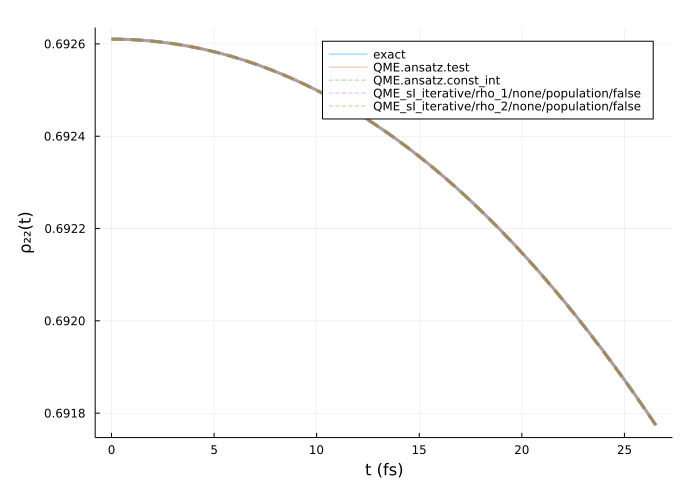

In [11]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[4][:, n, m]), label=sim_labels[4], linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[5][:, n, m]), label=sim_labels[5], linealpha = 0.5, linewidth = 3, linestyle = :dash)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500))

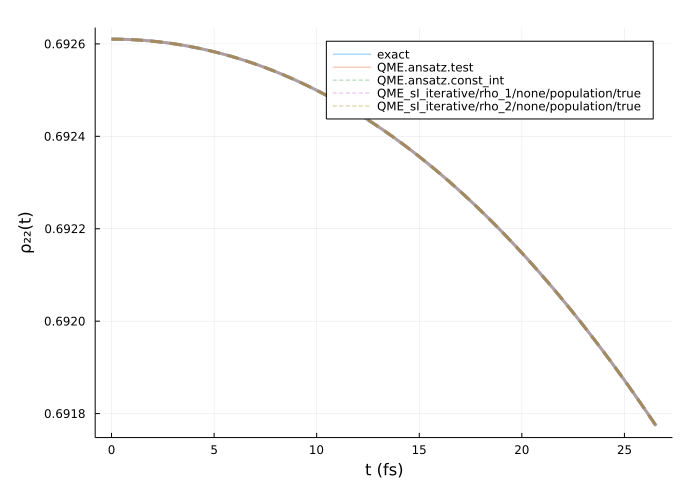

In [12]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[6][:, n, m]), label=sim_labels[6], linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[7][:, n, m]), label=sim_labels[7], linealpha = 0.5, linewidth = 3, linestyle = :dash)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500))

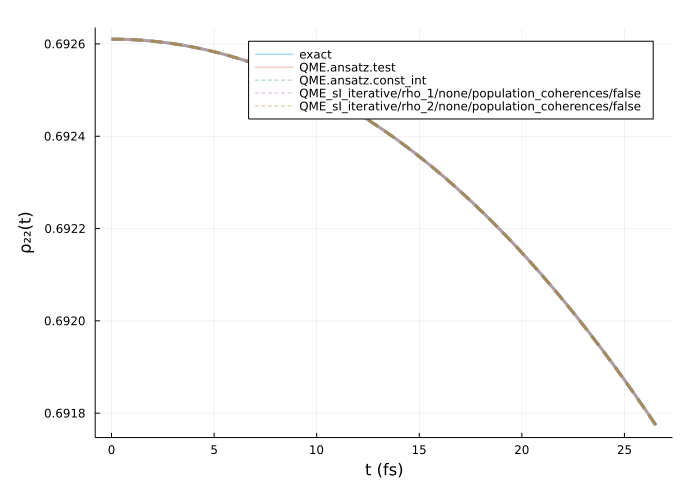

In [13]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[8][:, n, m]), label=sim_labels[8], linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[9][:, n, m]), label=sim_labels[9], linealpha = 0.5, linewidth = 3, linestyle = :dash)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500))

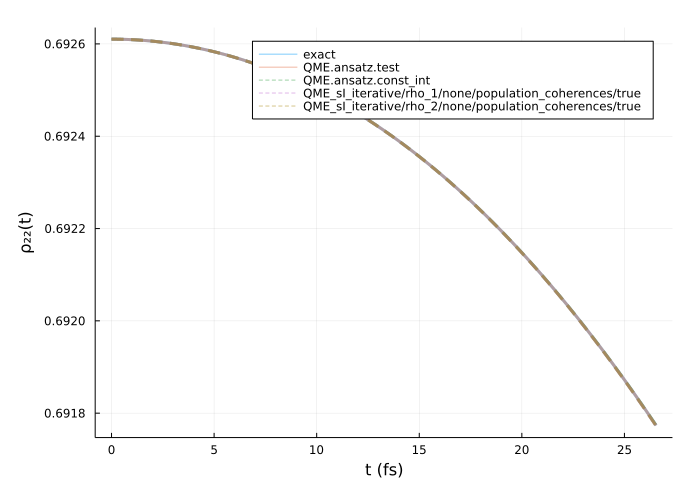

In [14]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[8][:, n, m]), label=sim_labels[10], linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[9][:, n, m]), label=sim_labels[11], linealpha = 0.5, linewidth = 3, linestyle = :dash)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500))